In [1]:
import keys
import wandb
wandb.login(key=keys.wandb)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/samnub/.netrc
wandb: Currently logged in as: samnub (samnub-university-of-surrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
from torch.utils.data import *
from lircst_ana_dataset import LircstAnaDataset
from torch import Generator

dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')

rand_generator = Generator().manual_seed(42) # The meaning of life, the universe and everything

dataset_train, dataset_valid, dataset_test = random_split(dataset, [0.8, 0.1, 0.1], generator=rand_generator)

print(f"Train set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_valid)}")
print(f"Test set size: {len(dataset_test)}")

Train set size: 14969
Validation set size: 1871
Test set size: 1871


In [3]:
model_args = {
    "ECD-Phys": {
        "train_dataset": dataset_train,
        "valid_dataset": dataset_valid,
        "test_dataset": dataset_test,
        "physics": True,  # Use physics-based loss
        "latent": False,  # Don't use latent diffusion
    },
    "ECD": {
        "train_dataset": dataset_train,
        "valid_dataset": dataset_valid,
        "test_dataset": dataset_test,
        "physics": False,  # Don't use physics-based loss
        "latent": False,  # Don't use latent diffusion
    },
    "ECLD-Phys": {
        "train_dataset": dataset_train,
        "valid_dataset": dataset_valid,
        "test_dataset": dataset_test,
        "physics": True,  # Use physics-based loss
        "latent": True,  # Use latent diffusion
    },
    "ECLD": {
        "train_dataset": dataset_train,
        "valid_dataset": dataset_valid,
        "test_dataset": dataset_test,
        "physics": False,  # Don't use physics-based loss
        "latent": True,  # Use latent diffusion
    },
}


In [ ]:
# Full pipeline
from encoded_conditional_diffusion import ECDiffusion
from util import generate_directory_name, get_latest_ckpt

# Setup Diffusion modules
import pytorch_lightning as pl
from Diffusion.EMA import EMA
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

pre_load: bool = False # Load the latest checkpoint if available
train_mode: bool = True
test_afterward: bool = True

def train():
    for name, model_arg in model_args.items():
        print(f"Training {name}...")

        model = ECDiffusion(**model_arg)

        # TODO: Bugged if pre_load is True
        default_root_dir, timestamp = generate_directory_name(name, get_latest_ckpt(name)[1] if pre_load else None)
        
        wandb_config = {
            "name": name,
            "physics": model_arg["physics"],
            "latent": model_arg["latent"],
            "timestamp": timestamp,
        }
        wandb_project = "lircst-diffusion"
        with wandb.init(project=wandb_project, config=wandb_config):
            print(f"Initialized wandb for {name} with config: {wandb_config}")

            trainer = pl.Trainer(
                max_epochs=200,
                max_steps=2e5,
                callbacks=[EMA(0.9999)],
                accelerator='gpu',
                devices=[0],
                num_sanity_val_steps=0,  # Disable sanity check on dataloader
                limit_val_batches=4,
                default_root_dir=default_root_dir,
            )
            
            trainer.fit(model, ckpt_path=get_latest_ckpt(name)[0] if pre_load else None)
            
            if test_afterward:
                trainer.test(model, ckpt_path=get_latest_ckpt(name)[0] if pre_load else None)

if train_mode:
    train()


/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training ECD-Phys...
Is Time embed used ?  True


/home/samnub/dev/lircst-diffusion/src/Diffusion/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                        | Params | Mode 
----------------------------------------------------------------------
0 | model         | EncodedCo

Initialized wandb for ECD-Phys with config: {'name': 'ECD-Phys', 'physics': True, 'latent': False, 'timestamp': 1751169208}


/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 0:  34%|███▍      | 320/936 [02:36<05:01,  2.05it/s, v_num=0, train_loss=0.113] 

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f45dc1d2900>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f4720aee470, raw_cell="# Display some samples from each model
import matp.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/samnub/dev/lircst-diffusion/src/diffusion.ipynb#W1sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Random dataset index: 0
Showing samples for ECD-Phys...
Is Time embed used ?  True
Loading checkpoint: epoch 99 | step 93600


diffusion sampling: 100%|██████████| 200/200 [00:07<00:00, 28.45it/s]


Sino (to feed into model) min: 0.0, max: 3.8283964386209846e-05
Output min: -1.0, max: 1.0
Encoded condition min: -1.0, max: 0.9891631603240967
Phan min: -1.0, max: 1.0


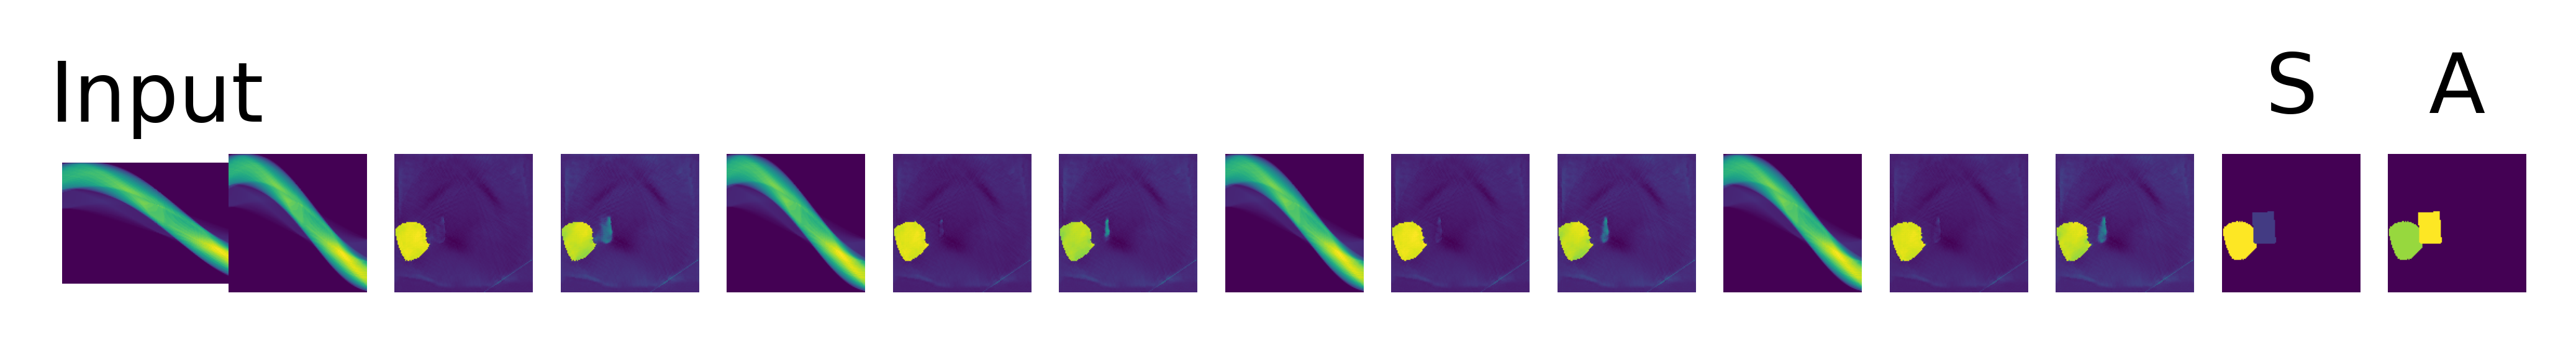

SSIM, PSNR:
Scatter channel: (np.float64(0.8367900192593843), np.float64(20.00114873501844))
Attenuation channel: (np.float64(0.7574705510118617), np.float64(14.328516188479853))
Scatter channel: (np.float64(0.828975440603084), np.float64(19.50543162243336))
Attenuation channel: (np.float64(0.7626192815917144), np.float64(13.930994596207626))
Scatter channel: (np.float64(0.8302551918513366), np.float64(19.66092465112834))
Attenuation channel: (np.float64(0.7552420559340348), np.float64(13.971293429460543))
Scatter channel: (np.float64(0.8347500216645907), np.float64(19.787793452539056))
Attenuation channel: (np.float64(0.7509209693718217), np.float64(14.01077495809681))
Showing samples for ECD...


AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f45dc1d2900>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f4720aee9c0, execution_count=5 error_before_exec=None error_in_exec='NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead. info=<ExecutionInfo object at 7f4720aee470, raw_cell="# Display some samples from each model
import matp.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/samnub/dev/lircst-diffusion/src/diffusion.ipynb#W1sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [5]:
# Display some samples from each model
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from encoded_conditional_diffusion import ECDiffusion
from util import get_latest_ckpt

def show_samples(model: ECDiffusion, dataset_idx: int|None=None, num_samples=4):
    phan, sino, _ = dataset_test[np.random.randint(0, len(dataset_test)) if dataset_idx is None else dataset_idx]
    #sino = torch.from_numpy(sino)

    sino = sino.cuda()  # Move to GPU
    #_, sino = model.preprocess(condition=sino.unsqueeze(0))
    #sino = sino.squeeze(0)  # Remove batch dimension

    batch_input = torch.stack(num_samples*[sino]).cuda()

    out, encoded_condition = model(batch_input, verbose=True)

    # Pre-process our data to be consistently -1 to 1 scaled
    phan = model.preprocess(image=phan.unsqueeze(0))[0].squeeze(0)
    out, _ = model.preprocess(image=out) # If the model is trained right, this should not be necessary


    # print min and max values of the output
    print(f"Sino (to feed into model) min: {sino.min().item()}, max: {sino.max().item()}")
    print(f"Output min: {out.min().item()}, max: {out.max().item()}")
    print(f"Encoded condition min: {encoded_condition.min().item()}, max: {encoded_condition.max().item()}")
    print(f"Phan min: {phan.min().item()}, max: {phan.max().item()}")



    plt.figure(dpi=800)
    plt.subplot(1,3+len(out)*2,1)
    plt.imshow(torch.sum(sino.cpu(), axis=2))
    plt.title('Input')
    plt.axis('off')
    for idx in range(out.shape[0]*3):
        if idx % 3 == 1:
            continue
        if idx % 3 == 2:
            continue
        plt.subplot(1,3+len(out)*3,idx+2)
        plt.imshow(torch.sum(encoded_condition[idx//3].detach().cpu(), axis=0))
        plt.axis('off')
        plt.subplot(1,3+len(out)*3,idx+3)
        plt.imshow(out[idx//3].detach().cpu()[0])
        plt.axis('off')
        plt.subplot(1,3+len(out)*3,idx+4)
        plt.imshow(out[idx//3].detach().cpu()[-1])
        plt.axis('off')
    plt.subplot(1,3+len(out)*3,2+len(out)*3)
    plt.imshow(phan[0].cpu())
    plt.title('S')
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,3+len(out)*3)
    plt.imshow(phan[1].cpu())
    plt.title('A')
    plt.axis('off')
    plt.show()

    def compare_images(imageA, imageB):
        # Compute SSIM between two images, and PSNR
        
        # If images aren't the same size, resize them
        if imageA.shape != imageB.shape:
            imageA = F.interpolate(imageA, size=imageB.shape[-2:], mode='bilinear', align_corners=False)

        # P.S. Scikit-image returns a value between -1 and 1, where 1 is a perfect match and -1 is a complete mismatch
        s = ssim(imageA, 
                imageB, 
                multichannel=True,
                data_range=imageB.max() - imageB.min())
        
        p = psnr(imageA, imageB, data_range=imageB.max() - imageB.min())

        return s, p
    
    print("SSIM, PSNR:")
    for idx in range(len(out)):
        print(f"Scatter channel: {compare_images(out[idx].detach().cpu().numpy()[0], phan[0].cpu().numpy())}")
        print(f"Attenuation channel: {compare_images(out[idx].detach().cpu().numpy()[-1], phan[1].cpu().numpy())}")

random_idx = 0 # np.random.randint(0, len(dataset_test))
print(f"Random dataset index: {random_idx}")

for name, model_arg in model_args.items():
    print(f"Showing samples for {name}...")

    model = ECDiffusion.load_from_checkpoint(
        get_latest_ckpt(name)[0],
        **model_arg
    ).cuda()

    show_samples(model, dataset_idx=random_idx)